In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import pickle

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

x = np.load("data/x_normalized.npy")
y = np.load("data/y.npy")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# seeing effects of changing certain XGB parameters

In [9]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7, 10],
        'n_estimators': [100, 200, 300],
        'learning_rate':[0.01, 0.05, 0.08]
        }

# model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_delta_step=0,
#        max_depth=10, min_child_weight=10, missing=None, n_estimators=200,
#        n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
#        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#        silent=True, subsample=0.8)

In [11]:
x = []
y_validations = []
y_trains = []
for min_child_weight in [1, 5, 10, 15, 20]:
    x.append(min_child_weight)
    model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=min_child_weight, missing=None, n_estimators=200,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
    model.fit(x_train, y_train)
    prob_preds = model.predict_proba(x_train)
    performance = roc_auc_score(y_train, prob_preds[:, 1])
    y_trains.append(performance)
    
    prob_preds = model.predict_proba(x_test)
    performance = roc_auc_score(y_test, prob_preds[:, 1])
    y_validations.append(performance)
    print "perfomance : " + str(performance)

perfomance : 0.796821844459209
perfomance : 0.7966530482857681
perfomance : 0.7978625901336096
perfomance : 0.7970457185287323
perfomance : 0.7967926883303892


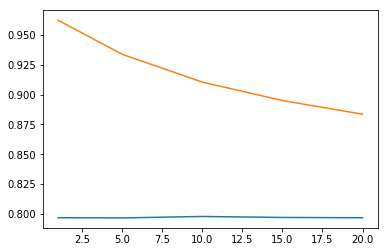

In [12]:
plt.plot(x, y_validations)
plt.plot(x, y_trains)
plt.show()

# getting feature importance from best models

In [2]:
def load_model(filename):
    with open(filename, 'rb') as f:
        clf = pickle.load(f)
        return clf

lgb_model = load_model("hehe/best_xgboost.pkl")
xgb_model = load_model("hehe/best_lgb.pkl")
rf_model = load_model("hehe/best_random_forest.pkl")

/anaconda/lib/python2.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
xgb_model.feature_importances_.shape

(381,)

In [4]:
df = pd.read_csv("data/train_2008.csv")
feature_labels = list(df)
features = feature_labels[1:-1]

In [5]:
def plot_feature_importance(feature_importances, features, n, title):
    top_n_indices = feature_importances.argsort()[-n:][::-1]
    true_labels = [features[i] for i in top_n_indices]
    true_importances = [feature_importances[i] for i in top_n_indices]
    fig, ax = plt.subplots()

    y_pos = np.arange(len(true_importances))

    ax.barh(y_pos, true_importances, align='center',
            color='salmon', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(true_labels)
    ax.invert_yaxis() 
    ax.set_xlabel('feature importance')
    ax.set_title(title)

    plt.show()

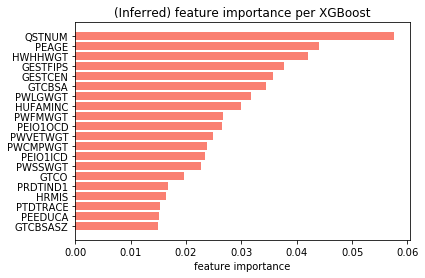

In [6]:
plot_feature_importance(xgb_model.feature_importances_, features, 20, '(Inferred) feature importance per XGBoost')

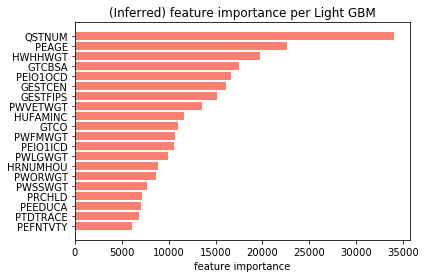

In [7]:
plot_feature_importance(lgb_model.feature_importances_, features, 20, '(Inferred) feature importance per Light GBM')

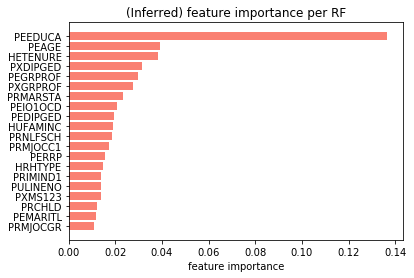

In [8]:
plot_feature_importance(rf_model.feature_importances_, features, 20, '(Inferred) feature importance per RF')

# generating effect graph for features

In [13]:
lgb_model_temp = load_model("hehe/lgb_model_temp.pkl")
xgb_model_temp = load_model("hehe/xgb_model_temp.pkl")
rf_model_temp = load_model("hehe/rf_model_temp.pkl")

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing


model = xgb_model_temp
feature_importances = lgb_model.feature_importances_

# get dataframe for scaled data
new_df = df.copy()
new_df = new_df.drop('id', 1)
new_df = new_df.drop('target',1)

column_labels = new_df.columns.values

x_temp = new_df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_temp)
new_df = pd.DataFrame(x_scaled, columns=column_labels)
new_df.head()

,HRMONTH,HRYEAR4,HURESPLI,HUFINAL,HUSPNISH,HETENURE,HEHOUSUT,HETELHHD,HETELAVL,HEPHONEO,...,PEDISPHY,PEDISDRS,PEDISOUT,PRDISFLG,PXDISEAR,PXDISEYE,PXDISREM,PXDISPHY,PXDISDRS,PXDISOUT
0,0.0,0.0,0.000000,0.990099,0.0,0.0,0.0,0.0,0.4,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.990099,0.0,0.5,0.0,0.0,0.4,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.4,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.076923,0.000000,0.0,0.0,0.0,0.0,0.4,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.076923,0.990099,0.0,0.0,0.0,0.0,0.4,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
feature = "PEEDUCA"



# inside for loop code here
tp = []
tn = []
fp = []
fn = []

predictions = model.predict_proba(x_test)[:,1]
predicted_labels = np.array([0 if prediction < 0.5 else 1 for prediction in predictions])
# predicted_labels = predicted_labels.reshape(-1,1)


feature_values = new_df[feature]

for i, label in enumerate(predicted_labels):
    if label == 0 and y_test[i] == 0:
        tn.append(feature_values[i])
    elif label == 1 and y_test[i] == 0:
        fp.append(feature_values[i])
    elif label == 0 and y_test[i] == 1:
        fn.append(feature_values[i])
    else:
        tp.append(feature_values[i])
        
tp_value = np.mean(tp)
fp_value = np.mean(fp)
fn_value = np.mean(fn)
tn_value = np.mean(tn)

tp_value


0.6167225950783

In [47]:
tp_vals = []
tn_vals = []
fp_vals = []
fn_vals = []

for j, feature in enumerate(features):
#     print "DOING FEATURE " + feature
    if j % 50 == 0:
        print "ON FEATURE " + str(j)
    tp = []
    tn = []
    fp = []
    fn = []

    predictions = model.predict_proba(x_test)[:,1]
    predicted_labels = np.array([0 if prediction < 0.5 else 1 for prediction in predictions])
    # predicted_labels = predicted_labels.reshape(-1,1)


    feature_values = new_df[feature]

    for i, label in enumerate(predicted_labels):
        if label == 0 and y_test[i] == 0:
            tn.append(feature_values[i])
        elif label == 1 and y_test[i] == 0:
            fp.append(feature_values[i])
        elif label == 0 and y_test[i] == 1:
            fn.append(feature_values[i])
        else:
            tp.append(feature_values[i])

    tp_value = np.mean(tp)
    fp_value = np.mean(fp)
    fn_value = np.mean(fn)
    tn_value = np.mean(tn)
    
    tp_vals.append(tp_value)
    fp_vals.append(fp_value)
    fn_vals.append(fn_value)
    tn_vals.append(tn_value)

ON FEATURE 0
ON FEATURE 50
ON FEATURE 100
ON FEATURE 150
ON FEATURE 200
ON FEATURE 250
ON FEATURE 300
ON FEATURE 350


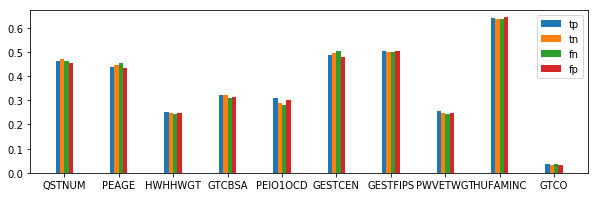

In [82]:
top_n_indices = feature_importances.argsort()[-10:][::-1]
true_labels = [features[i] for i in top_n_indices]
real_tp_vals = [tp_vals[i] for i in top_n_indices]
real_tn_vals = [tn_vals[i] for i in top_n_indices]
real_fp_vals = [fp_vals[i] for i in top_n_indices]
real_fn_vals = [fn_vals[i] for i in top_n_indices]

fig, ax = plt.subplots(figsize=(10, 3))
pos = list(range(len(top_n_indices)))
width = 0.08

plt.bar(pos, real_tp_vals, width, label='tp')
plt.bar([p + width for p in pos], real_tn_vals, width, label='tn')
plt.bar([p + 2*width for p in pos], real_fn_vals, width, label='fn')
plt.bar([p + 3*width for p in pos], real_fp_vals, width, label='fp')
plt.legend()

ax.set_xticks([p + 1.5*width for p in pos])
ax.set_xticklabels(true_labels)

plt.show()




In [67]:
real_tp_vals

[0.4627457901979079,
 0.4361790043073224,
 0.25322408397495094,
 0.3218162962463323,
 0.3070288220286447,
 0.4847994566954299,
 0.5039505796217206,
 0.2538199476789084,
 0.6378929706817379,
 0.03787596321153368]

In [68]:
real_fp_vals

[0.454206184797417,
 0.4325373134328358,
 0.2488944486524294,
 0.3124227386934673,
 0.3005892016393998,
 0.4787698412698413,
 0.5025454545454545,
 0.24697823266327626,
 0.6417543859649122,
 0.03210082304526749]

In [78]:
def generate_feature_sign(model, feature_importances, features):
    tp_vals = []
    tn_vals = []
    fp_vals = []
    fn_vals = []

    for j, feature in enumerate(features):
    #     print "DOING FEATURE " + feature
        if j % 50 == 0:
            print "ON FEATURE " + str(j)
        tp = []
        tn = []
        fp = []
        fn = []

        predictions = model.predict_proba(x_test)[:,1]
        predicted_labels = np.array([0 if prediction < 0.5 else 1 for prediction in predictions])
        # predicted_labels = predicted_labels.reshape(-1,1)


        feature_values = new_df[feature]

        for i, label in enumerate(predicted_labels):
            if label == 0 and y_test[i] == 0:
                tn.append(feature_values[i])
            elif label == 1 and y_test[i] == 0:
                fp.append(feature_values[i])
            elif label == 0 and y_test[i] == 1:
                fn.append(feature_values[i])
            else:
                tp.append(feature_values[i])

        tp_value = np.mean(tp)
        fp_value = np.mean(fp)
        fn_value = np.mean(fn)
        tn_value = np.mean(tn)

        tp_vals.append(tp_value)
        fp_vals.append(fp_value)
        fn_vals.append(fn_value)
        tn_vals.append(tn_value)
    
    top_n_indices = feature_importances.argsort()[-10:][::-1]
    true_labels = [features[i] for i in top_n_indices]
    real_tp_vals = [tp_vals[i] for i in top_n_indices]
    real_tn_vals = [tn_vals[i] for i in top_n_indices]
    real_fp_vals = [fp_vals[i] for i in top_n_indices]
    real_fn_vals = [fn_vals[i] for i in top_n_indices]

    fig, ax = plt.subplots(figsize=(10, 10))
    pos = list(range(len(top_n_indices)))
    width = 0.08

    plt.bar(pos, real_tp_vals, width, label='tp')
    plt.bar([p + width for p in pos], real_tn_vals, width, label='tn')
    plt.bar([p + 2*width for p in pos], real_fn_vals, width, label='fn')
    plt.bar([p + 3*width for p in pos], real_fp_vals, width, label='fp')
    plt.legend()
    ax.set_xticks([p + 1.5*width for p in pos])
    ax.set_xticklabels(true_labels)

    plt.show()

ON FEATURE 0
ON FEATURE 50
ON FEATURE 100
ON FEATURE 150
ON FEATURE 200
ON FEATURE 250
ON FEATURE 300
ON FEATURE 350


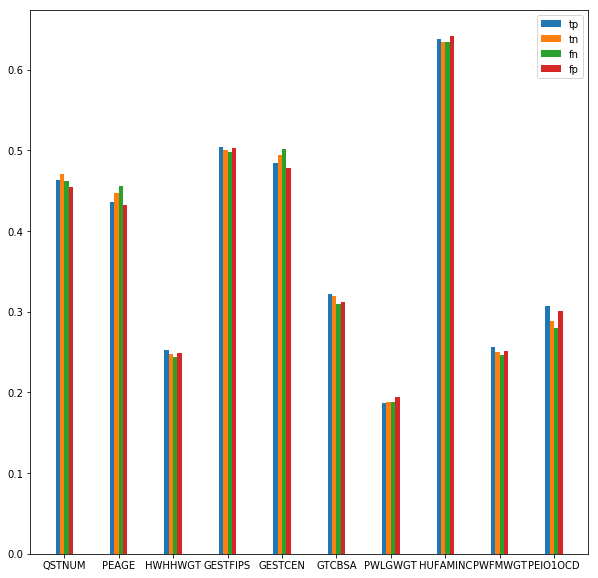

In [83]:
generate_feature_sign(xgb_model, xgb_model.feature_importances_, features)

ON FEATURE 0
ON FEATURE 50
ON FEATURE 100
ON FEATURE 150
ON FEATURE 200
ON FEATURE 250
ON FEATURE 300
ON FEATURE 350


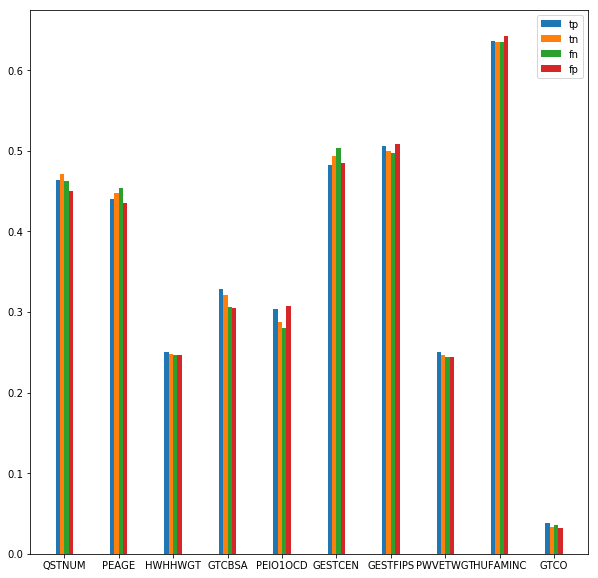

In [84]:
generate_feature_sign(lgb_model, lgb_model.feature_importances_, features)